# TP1: Estimation de Mouvement

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tqdm
import itertools

Tout d'abord, regardons nos 2 images à disposition:

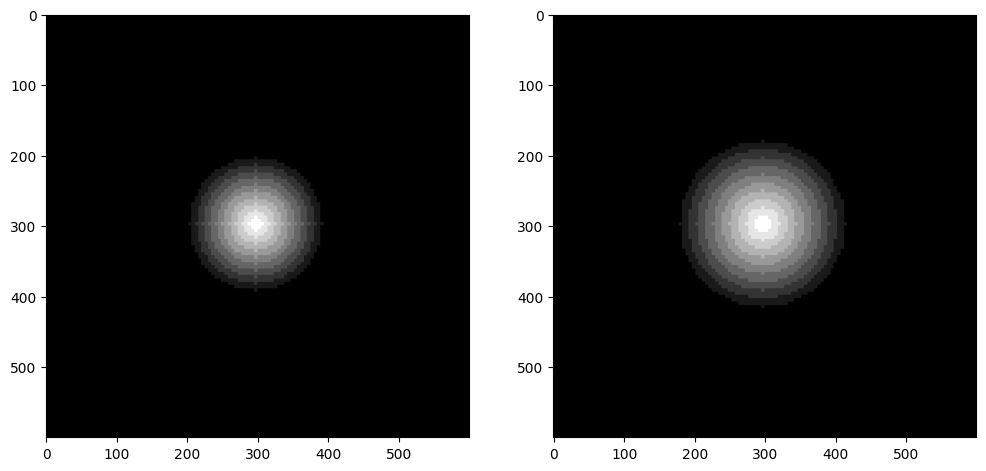

In [2]:
F1 = Image.open("../images_synthetiques/1.png").convert("L")
F2 = Image.open("../images_synthetiques/2.png").convert("L")
_, ax = plt.subplots(1,2, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
plt.show()

On les passe ensuite en arrays numpy pour les traiter

In [3]:
F1 = np.asarray(F1)
F2 = np.asarray(F2)

### Question A: Méthode par pixels

On défini nos fonctions pour pouvoir reconstruire l'image, et pour trouver les déplacements des pixels:

In [4]:
def reconstruct(image, displacementX, displacementY):
    x,y = np.meshgrid(np.arange(600), np.arange(600))
    res = image[x - displacementX, y - displacementY]
    return res

In [5]:
def find_new(y, x, r):
    if F1[x,y] == F2[x,y]:
        return (0,0)
    point = None
    lowest = None
    d = None
    for x2 in range(max(0, x-r), min(F1.shape[0], x + r)):
        for y2 in range(max(0, y-r), min(F1.shape[1], y + r)):
            diff = abs(F1[x,y].astype(int) - F2[x2,y2].astype(int))
            if not point or diff < lowest:
                lowest = diff
                point = (x2,y2)
                d = (x - x2) ** 2 + (y - y2) ** 2
                #print(f"new point: {point}")
            elif diff == lowest:
                d2 = (x - x2) ** 2 + (y - y2) ** 2
                if d > d2:
                    d = d2
                    point = (x2,y2)
                    #print(f"d = {d}, d2 = {d2}, point = {point}")
    return (point[0] - x, point[1] - y)

In [6]:
Dx = np.array([[0] * F1.shape[0]] * F1.shape[1])
Dy = np.array([[0] * F1.shape[0]] * F1.shape[1])

for i,j in tqdm.tqdm(itertools.product(range(600), range(600)), total=600*600):
    Dx[i,j], Dy[i,j] = find_new(i,j,20)

100%|██████████| 360000/360000 [01:19<00:00, 4520.59it/s]   


On peut maintenant afficher ces valeurs de déplacement trouvées pour chaque pixel. Le graph est zoomé pour mieux voir les flèches:

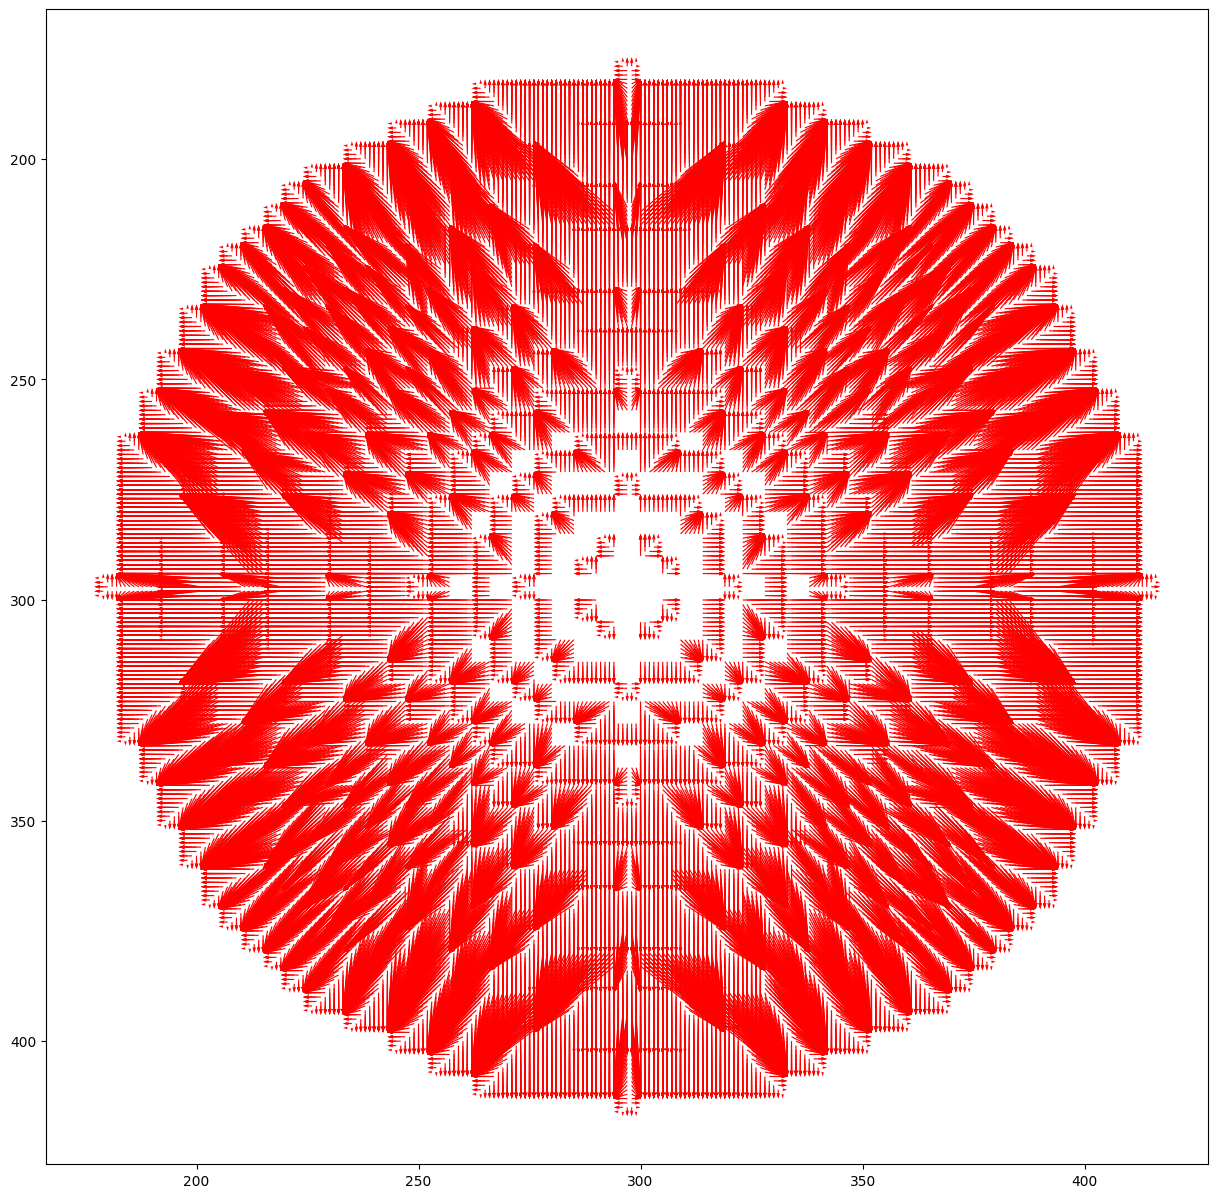

In [7]:
H, W = Dx.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

condition =  (Dx != 0) | (Dy != 0)
non_zero = np.where(condition)

testx = np.ones((H, W))
testy = np.zeros((H, W))


plt.figure(figsize=(15,15))
plt.gca().invert_yaxis()

plt.quiver(X[non_zero], Y[non_zero],
           Dx[non_zero], Dy[non_zero],
           color='red', angles='xy', scale_units='xy', scale=1, width=0.001)

#plt.xlim(0,600)
#plt.ylim(0,600)

plt.show()

On peut aussi reconstruire l'image à partir de ces déplacements pour voir le résultat:

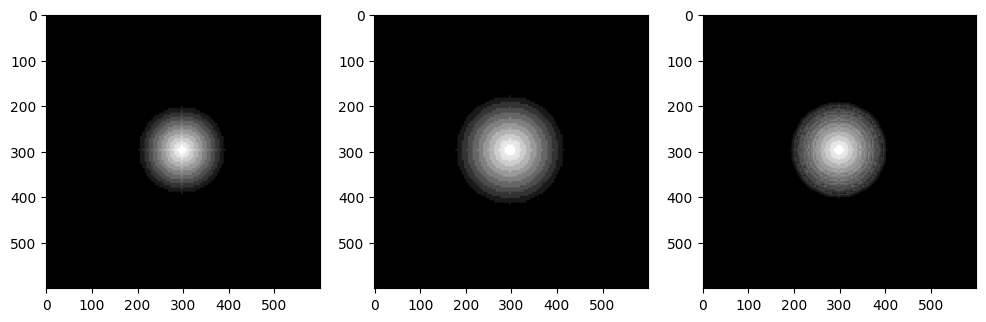

In [8]:
reconstructed = reconstruct(F1, Dx, Dy)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed, cmap='gray')
plt.show()

### Question B: Méthode par blocs

On fait le même processus, mais en découpant l'image par blocs cette fois.

In [9]:
def reconstruct_block(image, displacementX, displacementY, block_size):
    x,y = np.meshgrid(np.arange(600), np.arange(600))
    full_Dx = displacementX.repeat(block_size, axis=0).repeat(block_size, axis=1)
    full_Dy = displacementY.repeat(block_size, axis=0).repeat(block_size, axis=1)
    index = np.unravel_index((x - full_Dx).argmax(), (x - full_Dx).shape)
    index = (x - full_Dx).argmax()
    res = image[np.clip(x - full_Dx, 0, 599), np.clip(y - full_Dy, 0, 599)]
    return res

def intensity_B(M, x, y, block_size, offsetx=0, offsety=0):
    startx = x * block_size + offsetx
    starty = y * block_size + offsety
    endx = x * (block_size + 1) + offsetx
    endy = y * (block_size + 1) + offsety
    return M[startx: endx, starty:endy].astype(int).sum()

def find_new_block(by, bx, r, block_size):
    I = intensity_B(F1, bx, by, block_size)
    if I == intensity_B(F2, bx, by, block_size):
        return (0,0)
    point = None
    lowest = None
    d = None
    for offx in range(-r + 1, r):
        if bx * block_size - offx < 0 or bx * block_size + offx > 600:
            continue
        for offy in range(-r + 1, r):
            if by * block_size - offy < 0 or by * block_size + offy > 600:
                continue
            diff = abs(I - intensity_B(F2, bx ,by, block_size, offx, offy))
            if not point or diff < lowest:
                lowest = diff
                point = (bx * block_size + offx, by * block_size + offy)
                d = offx ** 2 + offy ** 2
            elif diff == lowest:
                d2 = offx ** 2 + offy ** 2
                if d > d2:
                    d = d2
                    point = (bx * block_size + offx, by * block_size + offy)
    return (point[0] - bx * block_size, point[1] - by * block_size)

On doit cette fois définir comme paramètre le nombre de blocs en lequel découper l'image. (il  faut s'assurer d'avoir un nombre par lequel on peut diviser la taille de l'image)

In [10]:
n_blocks = 30
block_size = 600 // n_blocks

B_Dx = np.array([[0] * n_blocks] * n_blocks)
B_Dy = np.array([[0] * n_blocks] * n_blocks)

for i in range(n_blocks):
    for j in range(n_blocks):
        B_Dx[i,j], B_Dy[i,j] = find_new_block(i, j, 20, block_size)

Encore une fois on peut montrer le graphe, qui contient beaucoup moins de valeurs, et afficher la reconstruction.

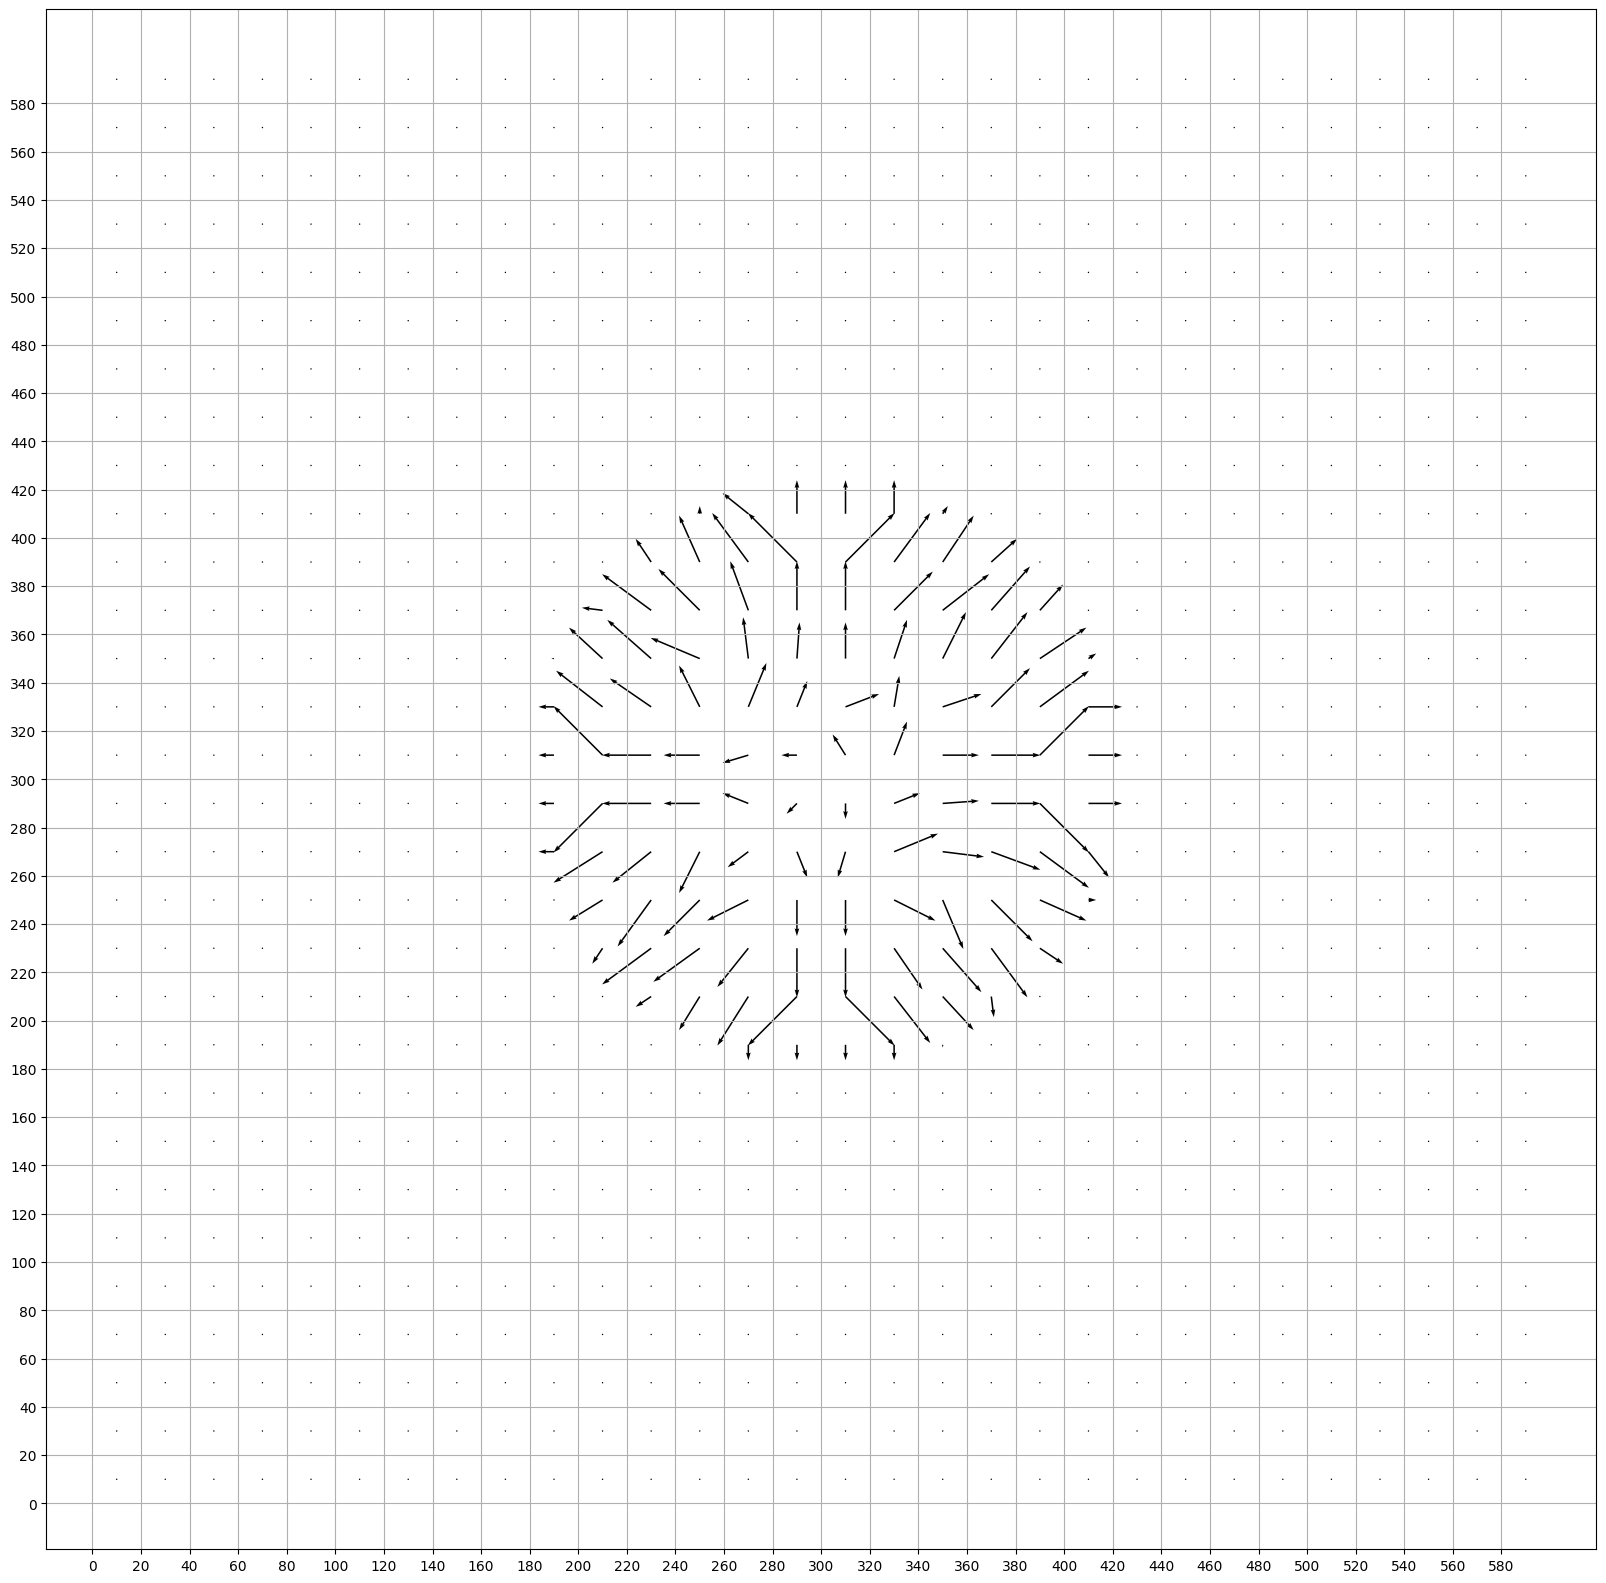

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(n_blocks) * block_size)
ax.set_yticks(np.arange(n_blocks) * block_size)
ax.grid()
O_x = np.tile(np.arange(block_size // 2, block_size * n_blocks, block_size), n_blocks)
O_y = np.arange(block_size // 2, block_size * n_blocks, block_size).repeat(n_blocks)
ax.quiver(O_x.flatten(), O_y.flatten(), B_Dx, B_Dy, scale=600, width=0.001)
plt.show()

In [12]:
reconstructed_smoothed = reconstruct_block(F1, B_Dx, B_Dy, block_size)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_smoothed, cmap='gray')
plt.show()

### Question C:

Testons avec un autre paramètre:

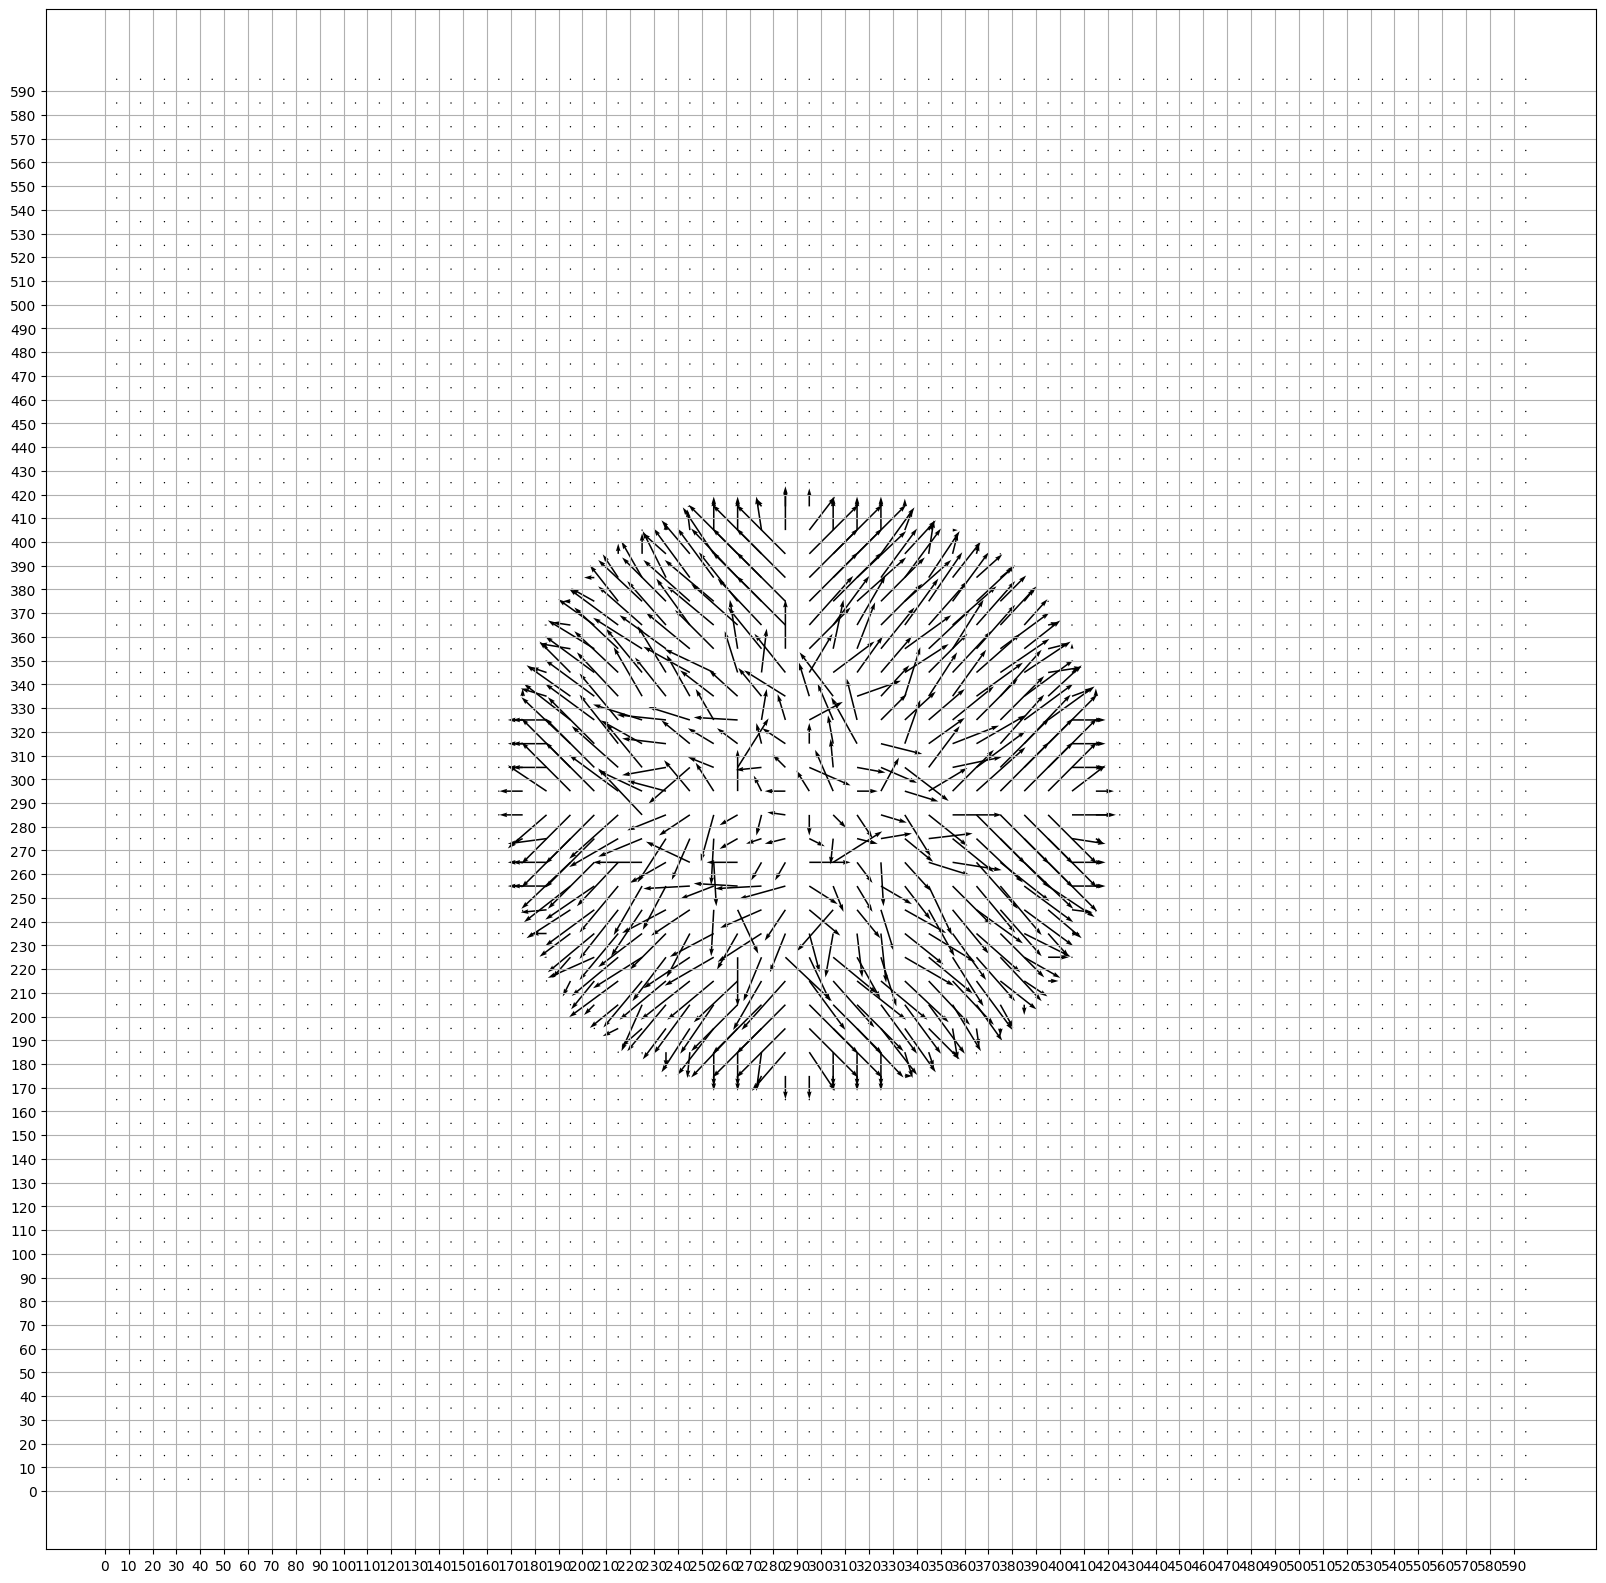

In [13]:
n_blocks_2 = 60
block_size_2 = 600 // n_blocks_2

B_Dx_2 = np.array([[0] * n_blocks_2] * n_blocks_2)
B_Dy_2 = np.array([[0] * n_blocks_2] * n_blocks_2)

for i in range(n_blocks_2):
    for j in range(n_blocks_2):
        B_Dx_2[i,j], B_Dy_2[i,j] = find_new_block(i, j, 20, block_size_2)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(n_blocks_2) * block_size_2)
ax.set_yticks(np.arange(n_blocks_2) * block_size_2)
ax.grid()
O_x_2 = np.tile(np.arange(block_size_2 // 2, block_size_2 * n_blocks_2, block_size_2), n_blocks_2)
O_y_2 = np.arange(block_size_2 // 2, block_size_2 * n_blocks_2, block_size_2).repeat(n_blocks_2)
ax.quiver(O_x_2.flatten(), O_y_2.flatten(), B_Dx_2, B_Dy_2, scale=600, width=0.001)
plt.show()



On peut remarquer que le champ est plus régulier avec des blocs plus grands.

### Question D: Régularisation

On peut maintenant rajouter une régularisation au champ de vecteur. Pour ceci, il faut passer par une descente de gradient au lieu d'une méthode itérative.

On doit aussi définir un coefficient de régularisation, qui ici à été mit à la meilleure valeure que j'ai expérimentée.

In [14]:
#On défini la fonction d'erreur
def error(dx, dy):
    F2_predicted = np.array([[0] * F1.shape[0]] * F1.shape[1])
    for i in range(600):
        for j in range(600):
            F2_predicted[i,j] = F2[i + dy[i,j],j + dx[i,j]]
    return abs(F1 - F2_predicted)

In [15]:
# On initialise avec le calcul pixelwise de base
Dx_smoothed = np.copy(Dx).astype('float')
Dy_smoothed = np.copy(Dy).astype('float')

# Pour avoir les valeurs limites de déplacement de chaque pixel:
X, Y = np.meshgrid(np.arange(600), np.arange(600))

coef = 0.01
iters = 50
smooth_coef = 0.01
for i in range(iters):
    gradX = np.gradient(Dx_smoothed)
    gradY = np.gradient(Dy_smoothed)

    gradX = np.square(gradX[0]) + np.square(gradX[1])
    gradY = np.square(gradY[0]) + np.square(gradY[1])

    E = error(np.rint(Dx_smoothed).astype(int), np.rint(Dy_smoothed).astype(int))
    grad = np.gradient(E)
    
    total_grad_Dx = grad[1] + smooth_coef * gradX
    total_grad_Dy = grad[0] + smooth_coef * gradY

    Dx_smoothed = np.clip(Dx_smoothed - (coef * total_grad_Dx), -X, 599 - X)
    Dy_smoothed = np.clip(Dy_smoothed - (coef * total_grad_Dy), -Y, 599 - Y)
    
    # Pour afficher l'erreur à chaque iter
    print(f"error at iter {i}: {E.sum()}")


error at iter 0: 10400
error at iter 1: 10400
error at iter 2: 10400
error at iter 3: 10400
error at iter 4: 13104
error at iter 5: 14560
error at iter 6: 14560
error at iter 7: 14560
error at iter 8: 15912
error at iter 9: 17264
error at iter 10: 17264
error at iter 11: 17264
error at iter 12: 18616
error at iter 13: 20072
error at iter 14: 19968
error at iter 15: 19968
error at iter 16: 21320
error at iter 17: 22724
error at iter 18: 22776
error at iter 19: 22724
error at iter 20: 24024
error at iter 21: 25324
error at iter 22: 25324
error at iter 23: 25324
error at iter 24: 26520
error at iter 25: 27560
error at iter 26: 27872
error at iter 27: 27818
error at iter 28: 29222
error at iter 29: 30210
error at iter 30: 29684
error at iter 31: 29940
error at iter 32: 31240
error at iter 33: 32330
error at iter 34: 32790
error at iter 35: 33040
error at iter 36: 34390
error at iter 37: 35530
error at iter 38: 35938
error at iter 39: 36190
error at iter 40: 37490
error at iter 41: 37592
er

Affichons le champ régularisé:

In [16]:
H, W = Dx_smoothed.shape
X, Y = np.meshgrid(np.arange(W), np.arange(H))

condition =  (Dx_smoothed != 0) | (Dy_smoothed != 0)
non_zero = np.where(condition)


plt.figure(figsize=(13,13))
plt.gca().invert_yaxis()
plt.quiver(X[non_zero], Y[non_zero],
           Dx_smoothed[non_zero], Dy_smoothed[non_zero],
           color='red', angles='xy', scale_units='xy', scale=5, width=0.001)
#plt.xlim(0,600)
#plt.ylim(0,600)
plt.show()

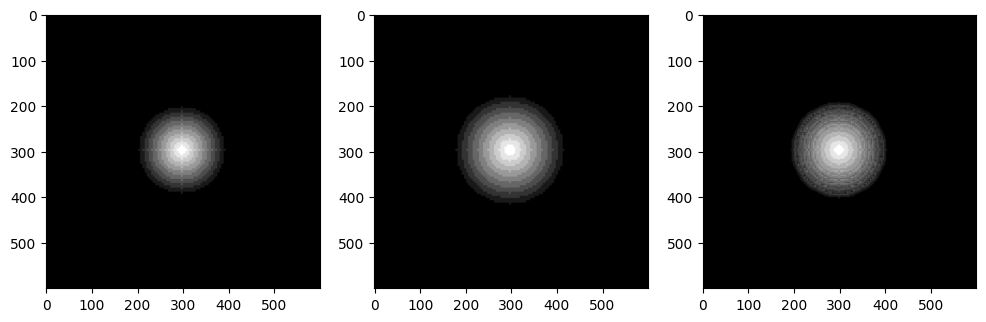

In [17]:
reconstructed_smoothed = reconstruct(F1, Dx_smoothed.round().astype(int), Dy_smoothed.round().astype(int))

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_smoothed, cmap='gray')
plt.show()

Appliquons maintenant cette même régularisation à la méthode par blocs:

In [18]:
def block_error(dx, dy, b_size, n_blocks):
    F2_predicted = np.array([[0] * F1.shape[0]] * F1.shape[1])
    blocks_predicted_errors = np.zeros((n_blocks, n_blocks))
    for i in range(n_blocks):
        for j in range(n_blocks):
            starti = i * b_size
            endi = (i+1) * b_size
            startj = j * b_size
            endj = (j+1) * b_size
            
            block_predicted = F2[starti + dy[i,j] : endi + dy[i,j], startj + dx[i,j] : endj + dx[i,j]]
            blocks_predicted_errors[i,j] = abs(F1[starti : endi, startj : endj] - block_predicted).sum() 
    return blocks_predicted_errors / (block_size ** 2)

In [19]:
# On initialise avec le calcul pixelwise de base
B_Dx_smoothed = np.copy(B_Dx).astype('float')
B_Dy_smoothed = np.copy(B_Dy).astype('float')

# Pour avoir les valeurs limites de déplacement de chaque bloc:
X, Y = np.meshgrid(np.arange(n_blocks), np.arange(n_blocks))
X *= block_size
Y *= block_size
coef = 0.01
iters = 100
smooth_coef = 0.01

for i in range(iters):
    gradX = np.gradient(B_Dx_smoothed)
    gradY = np.gradient(B_Dy_smoothed)

    gradX = np.square(gradX[0]) + np.square(gradX[1])
    gradY = np.square(gradY[0]) + np.square(gradY[1])

    E = block_error(np.rint(B_Dx_smoothed).astype(int), np.rint(B_Dy_smoothed).astype(int), block_size, n_blocks)
    grad = np.gradient(E)
    
    total_grad_Dx = grad[1] + smooth_coef * gradX
    total_grad_Dy = grad[0] + smooth_coef  * gradY

    B_Dx_smoothed = np.clip(B_Dx_smoothed - (coef * total_grad_Dx), -X, 599 - block_size - X)
    B_Dy_smoothed = np.clip(B_Dy_smoothed - (coef * total_grad_Dy), -Y, 599 - block_size - Y)

    index = np.unravel_index(np.argmax(B_Dx_smoothed), B_Dx_smoothed.shape)
    
    # Pour afficher l'erreur à chaque iter
    print(f"error at iter {i}: {E.sum()}")


error at iter 0: 3622.7900000000004
error at iter 1: 3675.4975000000004
error at iter 2: 3746.6125
error at iter 3: 3906.3550000000005
error at iter 4: 3918.9775
error at iter 5: 3910.2325000000005
error at iter 6: 4000.1175000000003
error at iter 7: 3985.0875
error at iter 8: 4002.3950000000004
error at iter 9: 3999.6925
error at iter 10: 4035.2574999999997
error at iter 11: 4050.3
error at iter 12: 4121.625
error at iter 13: 4123.795
error at iter 14: 4116.6925
error at iter 15: 4074.8324999999995
error at iter 16: 4036.955
error at iter 17: 4055.7725
error at iter 18: 3855.1325000000006
error at iter 19: 3861.0575
error at iter 20: 3690.0149999999994
error at iter 21: 3645.8999999999996
error at iter 22: 3542.3875
error at iter 23: 3408.0225
error at iter 24: 3396.4725
error at iter 25: 3196.59
error at iter 26: 3198.2275
error at iter 27: 3031.4425
error at iter 28: 2924.3075
error at iter 29: 2924.5924999999997
error at iter 30: 2746.1925
error at iter 31: 2691.4725000000003
error

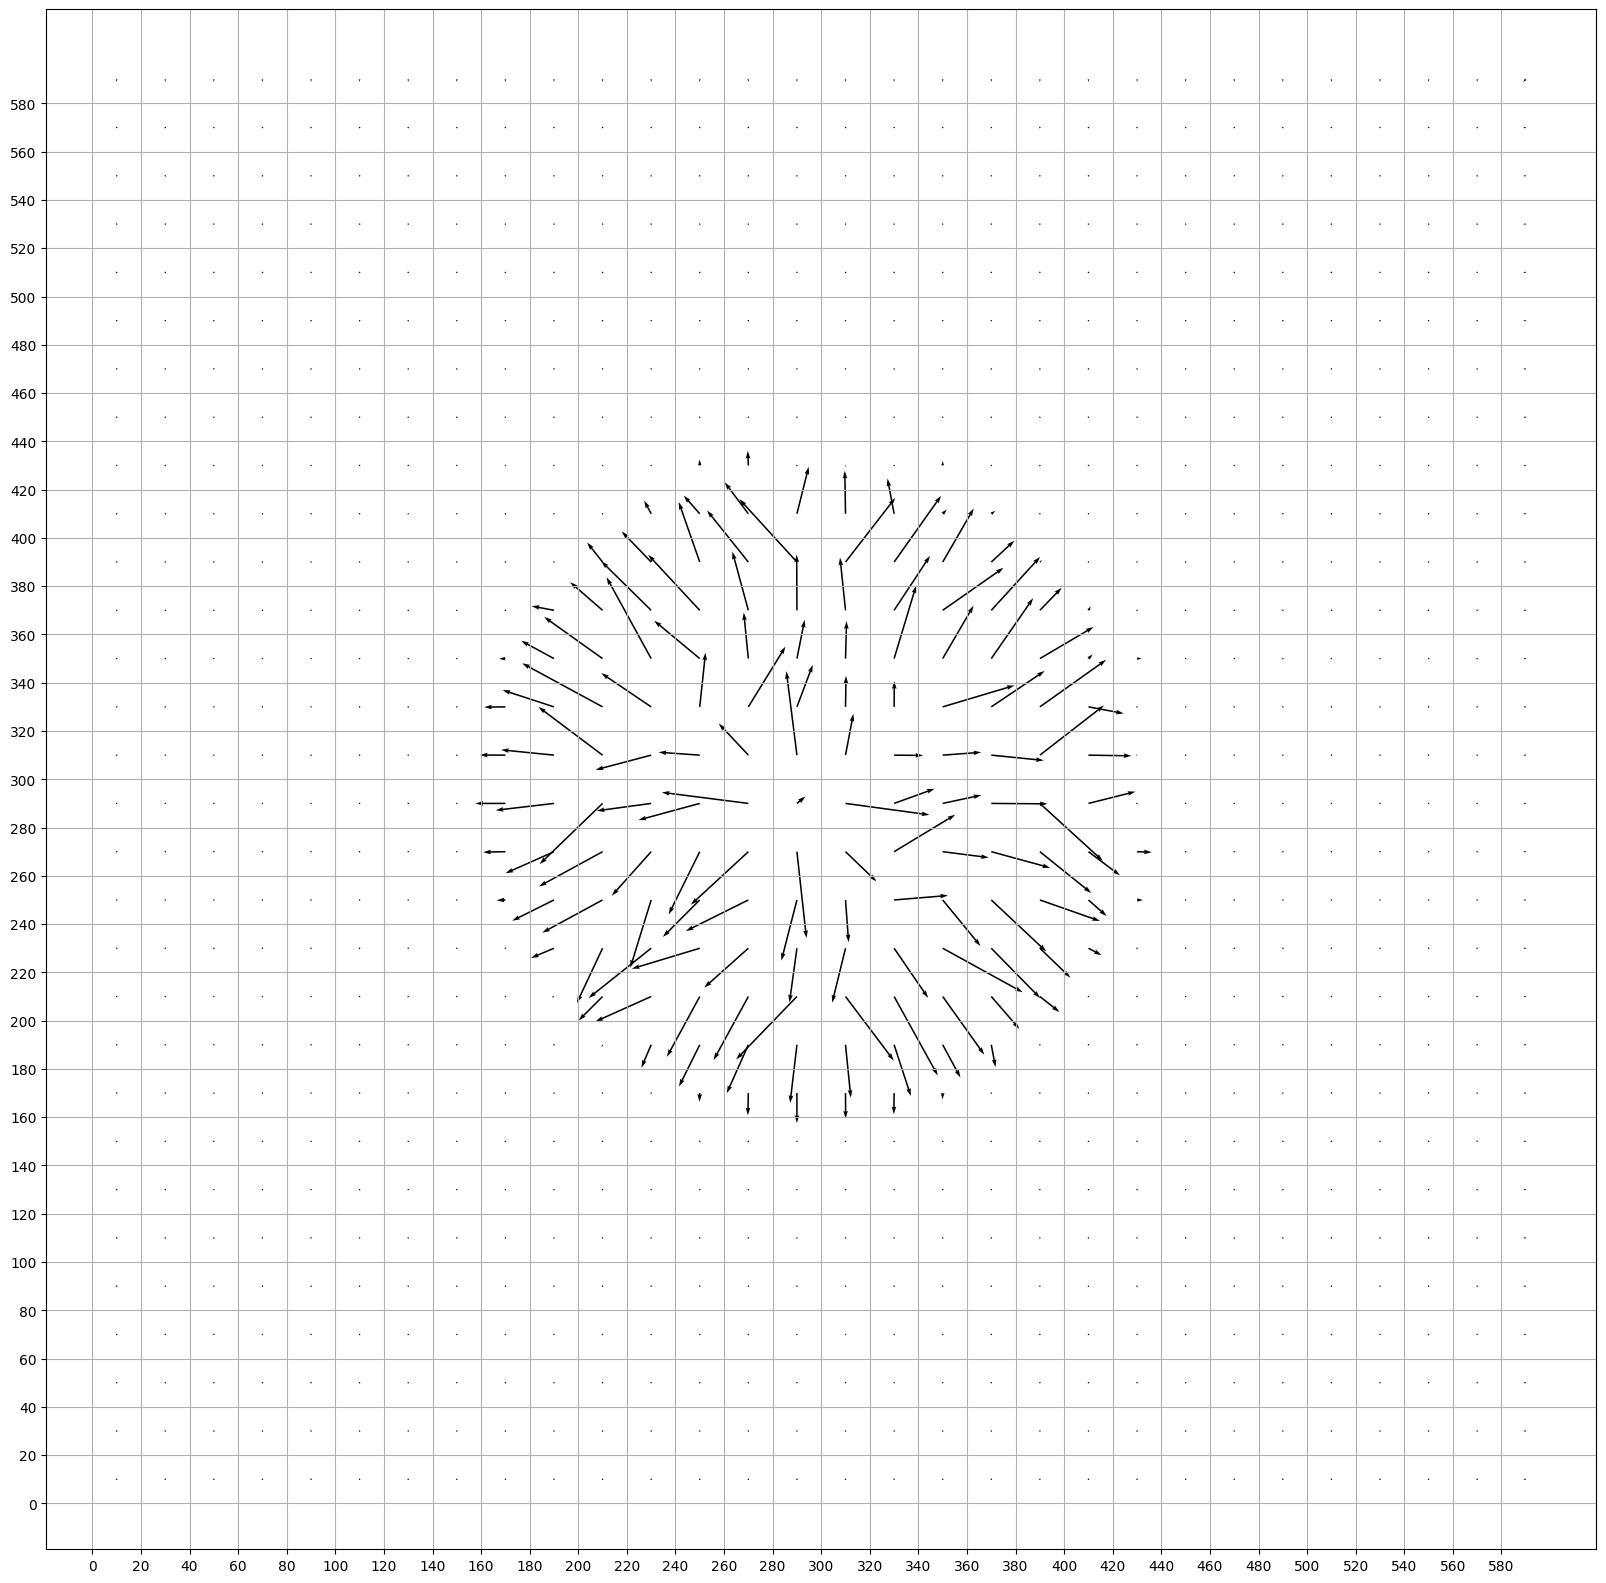

In [20]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(np.arange(n_blocks) * block_size)
ax.set_yticks(np.arange(n_blocks) * block_size)
ax.grid()
O_x = np.tile(np.arange(block_size // 2, block_size * n_blocks, block_size), n_blocks)
O_y = np.arange(block_size // 2, block_size * n_blocks, block_size).repeat(n_blocks)
ax.quiver(O_x.flatten(), O_y.flatten(), B_Dx_smoothed, B_Dy_smoothed, scale=600, width=0.001)
plt.show()

In [21]:
reconstructed_B_smoothed = reconstruct_block(F1, B_Dx_smoothed.round().astype(int), B_Dy_smoothed.round().astype(int), block_size)

_, ax = plt.subplots(1,3, figsize=(12, 12))
ax[0].imshow(np.asarray(F1), cmap='gray')
ax[1].imshow(np.asarray(F2), cmap='gray')
ax[2].imshow(reconstructed_B_smoothed, cmap='gray')
plt.show()

A noter dans cette implementation: les pixels ne peuvent pas sortir à cause du np.clip, ceci peut poser un problème par exemple si un pixel est censé disparaître de l'image.